<a href="https://colab.research.google.com/github/rajatha94/capnet-GAN/blob/master/capnet_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import glob
from tqdm import tqdm

from keras import layers, models, optimizers
from keras import backend as K
from keras import callbacks
from keras.utils import to_categorical
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Lambda, Multiply, Concatenate
from keras.layers import BatchNormalization, ZeroPadding2D, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np

import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plot
%matplotlib inline

Using TensorFlow backend.


In [0]:
def loadDataset(dataset, width, height, channels):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_train = np.expand_dims(x_train, axis=3)
  img_rows = width
  img_cols = height
  channels = channels
  img_shape = [img_rows, img_cols, channels]
  return x_train, img_shape

In [4]:
dataset, shape = loadDataset('mnist', 28, 28, 1)
print('Dataset: ' + str(dataset.shape))
print('Image Data: ' + str(shape))

Dataset: (60000, 28, 28, 1)
Image Data: [28, 28, 1]


In [0]:
def squash(vectors, axis=-1):
  squaredNorm = K.sum(K.square(vectors), axis, keepdims=True)
  scale = squaredNorm / (1 + squaredNorm) / K.sqrt(squaredNorm + K.epsilon())
  return scale * vectors

In [0]:
# Implementation of Discriminator
def buildDiscriminator():
  image = Input(shape=(shape[0], shape[1], shape[2]))

  # first Conv2D layer
  d = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='firstConvLayer')(image)
  d = LeakyReLU()(d)
  d = BatchNormalization(momentum=0.8)(d)

  # Capsule network implementation (Primarycaps and Digitcaps)
  # Primarycaps
  d = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycapsConvLayer')(d)
  d = Reshape(target_shape=[-1, 8], name='primarycapsReshapeLayer')(d)
  d = Lambda(squash, name='primarycapsSquashingFunction')(d)
  d = BatchNormalization(momentum=0.8)(d)
  # Digitcaps
  d = Flatten()(d)
  uCap = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uCapDigitcaps')(d)
  couplingCoefficient = Activation('softmax', name='softmaxLayer1')(uCap)
  couplingCoefficient = Dense(160)(couplingCoefficient)
  x = Multiply()([uCap, couplingCoefficient])
  layer1 = LeakyReLU()(x)
  couplingCoefficient = Activation('softmax', name='softmaxLayer2')(layer1) 
  couplingCoefficient = Dense(160)(couplingCoefficient)
  x = Multiply()([uCap, couplingCoefficient])
  layer2 = LeakyReLU()(x)
  couplingCoefficient = Activation('softmax', name='softmaxLayer3')(layer2) 
  couplingCoefficient = Dense(160)(couplingCoefficient) 
  x = Multiply()([uCap, couplingCoefficient])
  layer3 = LeakyReLU()(x)
  pred = Dense(1, activation='sigmoid')(layer3)
  return Model(image, pred)

In [7]:
discriminator = buildDiscriminator()
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
firstConvLayer (Conv2D)         (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 20, 20, 256)  0           firstConvLayer[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 20, 256)  1024        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
# Implementation of Generator (Similar to DCGAN Architecture)
def buildGenerator():
  noise = Input(shape=(100,))
  x = Dense(128 * 7 * 7, activation="relu")(noise)
  x = Reshape((7, 7, 128))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Conv2D(1, kernel_size=3, padding="same")(x)
  gen_out = Activation("tanh")(x)
  return Model(noise, gen_out)

In [9]:
generator = buildGenerator()
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0   

In [0]:
# Loss values for plotting
realDiscriminatorLoss = []
generatedDiscriminatorLoss = []
totalDiscriminatorLossandAcc = []
generatorLoss = []

In [11]:
# Creating combined model stacking generator and discriminator (used for training generator)
# Input random noise for generator
noise = Input(shape=(100,))
imageGenerated = generator(noise)
discriminator.trainable = False
# Keeping discriminator static
valid = discriminator(imageGenerated)
# Noise as input => generates images => determines validity 
combined = Model(noise, valid)
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         856705    
_________________________________________________________________
model_1 (Model)              (None, 1)                 6882881   
Total params: 7,739,586
Trainable params: 856,065
Non-trainable params: 6,883,521
_________________________________________________________________


In [0]:
def train(epochs, batch_size, interval):

  half_batch = int(batch_size / 2)
  for epoch in range(epochs):
    randomBatch = np.random.randint(0, dataset.shape[0], half_batch)
    realImages = dataset[randomBatch]
    randomNoise = np.random.normal(0, 1, (half_batch, 100))

    # Training the discriminator
    generatedImages = generator.predict(randomNoise) # generate a half batch of new images
    disRealLoss = discriminator.train_on_batch(realImages, np.ones((half_batch, 1))*0.85)
    disGenLoss = discriminator.train_on_batch(generatedImages, np.zeros((half_batch, 1)))
    totalDisLossAcc = 0.5 * np.add(disRealLoss, disGenLoss)

    # Training Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    genLoss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    #Progress
    print ("%d [Discriminator loss: %f, Accuracy: %.2f%%] [Generator loss: %f]" % (epoch, totalDisLossAcc[0], 100*totalDisLossAcc[1], genLoss))
    realDiscriminatorLoss.append(disRealLoss)
    generatedDiscriminatorLoss.append(disGenLoss)
    totalDiscriminatorLossandAcc.append(totalDisLossAcc)
    generatorLoss.append(genLoss)

    if epoch % interval == 0:
      r, c = 5, 5
      noise = np.random.normal(0, 1, (r * c, 100))
      generatedImages = generator.predict(noise)
      generatedImages = 0.5 * generatedImages + 0.5
      fig, axis = plot.subplots(r, c)
      count = 0
      # Creating output images
      for i in range(r):
        for j in range(c):
          axis[i,j].imshow(generatedImages[count, :,:,0], cmap='gray')
          axis[i,j].axis('off')
          count += 1
      plot.show()
      plot.close()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 0.552195, Accuracy: 34.38%] [Generator loss: 1.226091]


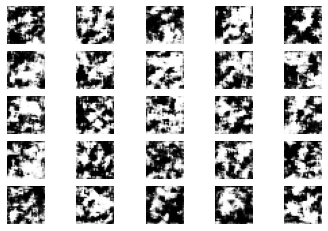

1 [Discriminator loss: 0.555403, Accuracy: 34.38%] [Generator loss: 1.129665]
2 [Discriminator loss: 0.689508, Accuracy: 21.88%] [Generator loss: 0.871132]
3 [Discriminator loss: 0.578307, Accuracy: 21.88%] [Generator loss: 0.973583]
4 [Discriminator loss: 0.626406, Accuracy: 28.12%] [Generator loss: 0.976008]
5 [Discriminator loss: 0.659940, Accuracy: 18.75%] [Generator loss: 0.788291]
6 [Discriminator loss: 0.637654, Accuracy: 18.75%] [Generator loss: 0.806473]
7 [Discriminator loss: 0.622266, Accuracy: 15.62%] [Generator loss: 0.964560]
8 [Discriminator loss: 0.611696, Accuracy: 34.38%] [Generator loss: 0.941988]
9 [Discriminator loss: 0.636452, Accuracy: 18.75%] [Generator loss: 1.148841]
10 [Discriminator loss: 0.591822, Accuracy: 31.25%] [Generator loss: 1.275341]
11 [Discriminator loss: 0.587288, Accuracy: 34.38%] [Generator loss: 1.066754]
12 [Discriminator loss: 0.543136, Accuracy: 34.38%] [Generator loss: 1.126965]
13 [Discriminator loss: 0.572298, Accuracy: 31.25%] [Generato

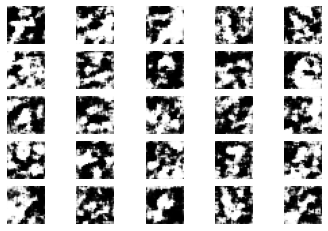

26 [Discriminator loss: 0.472504, Accuracy: 37.50%] [Generator loss: 1.123724]
27 [Discriminator loss: 0.502227, Accuracy: 37.50%] [Generator loss: 1.244535]
28 [Discriminator loss: 0.522846, Accuracy: 37.50%] [Generator loss: 1.362180]
29 [Discriminator loss: 0.575038, Accuracy: 31.25%] [Generator loss: 1.212987]
30 [Discriminator loss: 0.619181, Accuracy: 31.25%] [Generator loss: 1.427992]
31 [Discriminator loss: 0.564016, Accuracy: 37.50%] [Generator loss: 1.295366]
32 [Discriminator loss: 0.522314, Accuracy: 40.62%] [Generator loss: 1.105278]
33 [Discriminator loss: 0.559132, Accuracy: 31.25%] [Generator loss: 1.323945]
34 [Discriminator loss: 0.463095, Accuracy: 46.88%] [Generator loss: 1.159936]
35 [Discriminator loss: 0.446210, Accuracy: 37.50%] [Generator loss: 1.408218]
36 [Discriminator loss: 0.435925, Accuracy: 40.62%] [Generator loss: 1.369832]
37 [Discriminator loss: 0.544949, Accuracy: 43.75%] [Generator loss: 1.890738]
38 [Discriminator loss: 0.522572, Accuracy: 37.50%] 

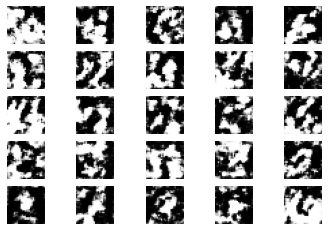

51 [Discriminator loss: 0.412070, Accuracy: 43.75%] [Generator loss: 1.539731]
52 [Discriminator loss: 0.438506, Accuracy: 43.75%] [Generator loss: 1.832873]
53 [Discriminator loss: 0.365021, Accuracy: 50.00%] [Generator loss: 2.259617]
54 [Discriminator loss: 0.533538, Accuracy: 46.88%] [Generator loss: 1.887260]
55 [Discriminator loss: 0.432995, Accuracy: 43.75%] [Generator loss: 1.910553]
56 [Discriminator loss: 0.353804, Accuracy: 50.00%] [Generator loss: 2.138794]
57 [Discriminator loss: 0.328786, Accuracy: 50.00%] [Generator loss: 2.191475]
58 [Discriminator loss: 0.299323, Accuracy: 50.00%] [Generator loss: 2.412227]
59 [Discriminator loss: 0.349918, Accuracy: 46.88%] [Generator loss: 2.541212]
60 [Discriminator loss: 0.288078, Accuracy: 50.00%] [Generator loss: 2.978834]
61 [Discriminator loss: 0.357711, Accuracy: 50.00%] [Generator loss: 2.261148]
62 [Discriminator loss: 0.405748, Accuracy: 40.62%] [Generator loss: 2.315178]
63 [Discriminator loss: 0.422881, Accuracy: 43.75%] 

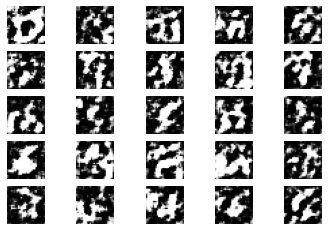

76 [Discriminator loss: 0.448437, Accuracy: 46.88%] [Generator loss: 1.731263]
77 [Discriminator loss: 0.408059, Accuracy: 40.62%] [Generator loss: 2.027357]
78 [Discriminator loss: 0.340296, Accuracy: 50.00%] [Generator loss: 1.983150]
79 [Discriminator loss: 0.445172, Accuracy: 43.75%] [Generator loss: 2.057468]
80 [Discriminator loss: 0.390850, Accuracy: 46.88%] [Generator loss: 2.009371]
81 [Discriminator loss: 0.360766, Accuracy: 50.00%] [Generator loss: 2.383054]
82 [Discriminator loss: 0.486199, Accuracy: 40.62%] [Generator loss: 1.968809]
83 [Discriminator loss: 0.398270, Accuracy: 43.75%] [Generator loss: 2.596394]
84 [Discriminator loss: 0.531438, Accuracy: 46.88%] [Generator loss: 2.023528]
85 [Discriminator loss: 0.338853, Accuracy: 46.88%] [Generator loss: 2.534638]
86 [Discriminator loss: 0.350837, Accuracy: 50.00%] [Generator loss: 2.561366]
87 [Discriminator loss: 0.414601, Accuracy: 50.00%] [Generator loss: 1.495506]
88 [Discriminator loss: 0.431480, Accuracy: 37.50%] 

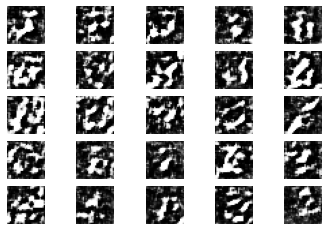

101 [Discriminator loss: 0.364592, Accuracy: 46.88%] [Generator loss: 2.134241]
102 [Discriminator loss: 0.414223, Accuracy: 50.00%] [Generator loss: 1.974349]
103 [Discriminator loss: 0.335753, Accuracy: 50.00%] [Generator loss: 2.453598]
104 [Discriminator loss: 0.361119, Accuracy: 46.88%] [Generator loss: 2.538124]
105 [Discriminator loss: 0.458255, Accuracy: 43.75%] [Generator loss: 2.464847]
106 [Discriminator loss: 0.388072, Accuracy: 46.88%] [Generator loss: 2.224941]
107 [Discriminator loss: 0.335535, Accuracy: 50.00%] [Generator loss: 2.695317]
108 [Discriminator loss: 0.455679, Accuracy: 43.75%] [Generator loss: 2.507920]
109 [Discriminator loss: 0.313080, Accuracy: 50.00%] [Generator loss: 2.936646]
110 [Discriminator loss: 0.490001, Accuracy: 46.88%] [Generator loss: 1.660984]
111 [Discriminator loss: 0.456631, Accuracy: 40.62%] [Generator loss: 3.452494]
112 [Discriminator loss: 0.469904, Accuracy: 46.88%] [Generator loss: 2.350552]
113 [Discriminator loss: 0.394656, Accur

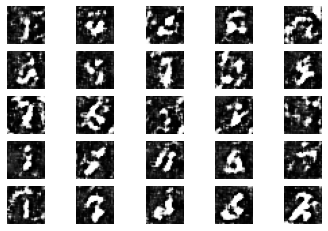

126 [Discriminator loss: 0.503893, Accuracy: 50.00%] [Generator loss: 1.770548]
127 [Discriminator loss: 0.329669, Accuracy: 50.00%] [Generator loss: 2.264296]
128 [Discriminator loss: 0.331705, Accuracy: 50.00%] [Generator loss: 3.279931]
129 [Discriminator loss: 0.818019, Accuracy: 34.38%] [Generator loss: 1.594263]
130 [Discriminator loss: 0.392027, Accuracy: 43.75%] [Generator loss: 2.063499]
131 [Discriminator loss: 0.650144, Accuracy: 34.38%] [Generator loss: 2.117213]
132 [Discriminator loss: 0.504561, Accuracy: 43.75%] [Generator loss: 2.084050]
133 [Discriminator loss: 0.391905, Accuracy: 46.88%] [Generator loss: 2.438727]
134 [Discriminator loss: 0.786457, Accuracy: 28.12%] [Generator loss: 1.720492]
135 [Discriminator loss: 0.503902, Accuracy: 37.50%] [Generator loss: 3.241504]
136 [Discriminator loss: 0.857579, Accuracy: 34.38%] [Generator loss: 2.244970]
137 [Discriminator loss: 0.498799, Accuracy: 43.75%] [Generator loss: 2.573819]
138 [Discriminator loss: 0.542732, Accur

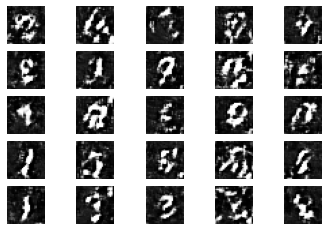

151 [Discriminator loss: 0.565187, Accuracy: 46.88%] [Generator loss: 2.120791]
152 [Discriminator loss: 0.681560, Accuracy: 31.25%] [Generator loss: 2.300390]
153 [Discriminator loss: 0.602949, Accuracy: 46.88%] [Generator loss: 2.378018]
154 [Discriminator loss: 0.535855, Accuracy: 43.75%] [Generator loss: 2.061624]
155 [Discriminator loss: 0.502488, Accuracy: 46.88%] [Generator loss: 1.827394]
156 [Discriminator loss: 0.531267, Accuracy: 43.75%] [Generator loss: 1.980722]
157 [Discriminator loss: 0.507125, Accuracy: 46.88%] [Generator loss: 1.790896]
158 [Discriminator loss: 0.648192, Accuracy: 25.00%] [Generator loss: 2.465207]
159 [Discriminator loss: 0.563045, Accuracy: 50.00%] [Generator loss: 2.183936]
160 [Discriminator loss: 0.553136, Accuracy: 40.62%] [Generator loss: 1.800315]
161 [Discriminator loss: 0.515169, Accuracy: 43.75%] [Generator loss: 2.020511]
162 [Discriminator loss: 0.526100, Accuracy: 46.88%] [Generator loss: 2.114585]
163 [Discriminator loss: 0.469365, Accur

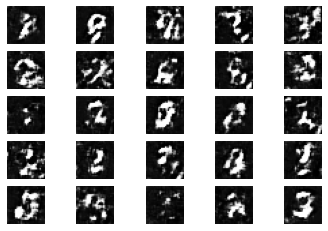

176 [Discriminator loss: 0.403387, Accuracy: 46.88%] [Generator loss: 2.088027]
177 [Discriminator loss: 0.558089, Accuracy: 40.62%] [Generator loss: 2.414239]
178 [Discriminator loss: 0.559393, Accuracy: 40.62%] [Generator loss: 2.087097]
179 [Discriminator loss: 0.497624, Accuracy: 46.88%] [Generator loss: 2.234433]
180 [Discriminator loss: 0.495013, Accuracy: 50.00%] [Generator loss: 1.877835]
181 [Discriminator loss: 0.503424, Accuracy: 43.75%] [Generator loss: 2.231391]
182 [Discriminator loss: 0.722832, Accuracy: 46.88%] [Generator loss: 1.515462]
183 [Discriminator loss: 0.533784, Accuracy: 31.25%] [Generator loss: 1.773087]
184 [Discriminator loss: 0.556173, Accuracy: 40.62%] [Generator loss: 2.158258]
185 [Discriminator loss: 0.628521, Accuracy: 43.75%] [Generator loss: 2.086142]
186 [Discriminator loss: 0.482376, Accuracy: 43.75%] [Generator loss: 2.240197]
187 [Discriminator loss: 0.559031, Accuracy: 46.88%] [Generator loss: 1.900038]
188 [Discriminator loss: 0.737820, Accur

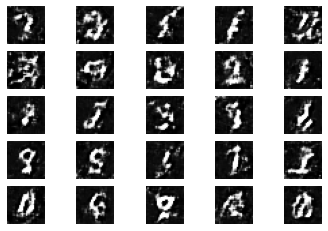

201 [Discriminator loss: 0.609224, Accuracy: 40.62%] [Generator loss: 1.706313]
202 [Discriminator loss: 0.405969, Accuracy: 46.88%] [Generator loss: 2.237698]
203 [Discriminator loss: 0.591182, Accuracy: 37.50%] [Generator loss: 1.849706]
204 [Discriminator loss: 0.425551, Accuracy: 46.88%] [Generator loss: 2.414622]
205 [Discriminator loss: 0.527954, Accuracy: 50.00%] [Generator loss: 2.168443]
206 [Discriminator loss: 0.535115, Accuracy: 40.62%] [Generator loss: 2.492893]
207 [Discriminator loss: 0.563542, Accuracy: 43.75%] [Generator loss: 1.756577]
208 [Discriminator loss: 0.539413, Accuracy: 46.88%] [Generator loss: 2.106902]
209 [Discriminator loss: 0.409341, Accuracy: 46.88%] [Generator loss: 2.230904]
210 [Discriminator loss: 0.437279, Accuracy: 50.00%] [Generator loss: 2.283079]
211 [Discriminator loss: 0.568496, Accuracy: 43.75%] [Generator loss: 2.151501]
212 [Discriminator loss: 0.468427, Accuracy: 43.75%] [Generator loss: 2.446627]
213 [Discriminator loss: 0.549371, Accur

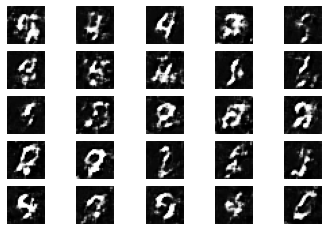

226 [Discriminator loss: 0.476106, Accuracy: 50.00%] [Generator loss: 2.172563]
227 [Discriminator loss: 0.715425, Accuracy: 28.12%] [Generator loss: 1.767620]
228 [Discriminator loss: 0.607556, Accuracy: 37.50%] [Generator loss: 2.272966]
229 [Discriminator loss: 0.394967, Accuracy: 50.00%] [Generator loss: 2.480139]
230 [Discriminator loss: 0.524719, Accuracy: 46.88%] [Generator loss: 1.919333]
231 [Discriminator loss: 0.546242, Accuracy: 40.62%] [Generator loss: 2.118651]
232 [Discriminator loss: 0.409286, Accuracy: 50.00%] [Generator loss: 2.114019]
233 [Discriminator loss: 0.552480, Accuracy: 43.75%] [Generator loss: 2.032943]
234 [Discriminator loss: 0.445590, Accuracy: 46.88%] [Generator loss: 2.463227]
235 [Discriminator loss: 0.633687, Accuracy: 37.50%] [Generator loss: 1.903816]
236 [Discriminator loss: 0.588684, Accuracy: 40.62%] [Generator loss: 2.005668]
237 [Discriminator loss: 0.580493, Accuracy: 43.75%] [Generator loss: 1.838607]
238 [Discriminator loss: 0.385268, Accur

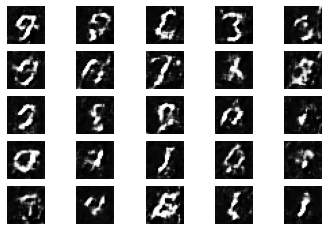

251 [Discriminator loss: 0.548732, Accuracy: 50.00%] [Generator loss: 1.867389]
252 [Discriminator loss: 0.435395, Accuracy: 46.88%] [Generator loss: 2.025951]
253 [Discriminator loss: 0.439649, Accuracy: 46.88%] [Generator loss: 2.298009]
254 [Discriminator loss: 0.443917, Accuracy: 50.00%] [Generator loss: 2.147479]
255 [Discriminator loss: 0.638935, Accuracy: 40.62%] [Generator loss: 2.002469]
256 [Discriminator loss: 0.500014, Accuracy: 40.62%] [Generator loss: 2.046783]
257 [Discriminator loss: 0.518399, Accuracy: 50.00%] [Generator loss: 2.180224]
258 [Discriminator loss: 0.500342, Accuracy: 37.50%] [Generator loss: 1.798073]
259 [Discriminator loss: 0.449008, Accuracy: 50.00%] [Generator loss: 2.370780]
260 [Discriminator loss: 0.559389, Accuracy: 40.62%] [Generator loss: 2.656562]
261 [Discriminator loss: 0.452714, Accuracy: 46.88%] [Generator loss: 1.891110]
262 [Discriminator loss: 0.598839, Accuracy: 40.62%] [Generator loss: 2.284306]
263 [Discriminator loss: 0.389820, Accur

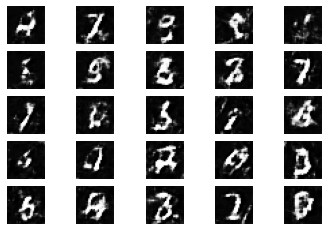

276 [Discriminator loss: 0.518836, Accuracy: 50.00%] [Generator loss: 2.084540]
277 [Discriminator loss: 0.473741, Accuracy: 46.88%] [Generator loss: 1.808081]
278 [Discriminator loss: 0.495628, Accuracy: 43.75%] [Generator loss: 2.254842]
279 [Discriminator loss: 0.619110, Accuracy: 40.62%] [Generator loss: 1.286141]
280 [Discriminator loss: 0.419934, Accuracy: 46.88%] [Generator loss: 1.989292]
281 [Discriminator loss: 0.399636, Accuracy: 43.75%] [Generator loss: 2.286274]
282 [Discriminator loss: 0.521251, Accuracy: 46.88%] [Generator loss: 2.016371]
283 [Discriminator loss: 0.393472, Accuracy: 46.88%] [Generator loss: 2.278088]
284 [Discriminator loss: 0.428162, Accuracy: 50.00%] [Generator loss: 2.336978]
285 [Discriminator loss: 0.565101, Accuracy: 46.88%] [Generator loss: 1.926967]
286 [Discriminator loss: 0.456637, Accuracy: 46.88%] [Generator loss: 2.237111]
287 [Discriminator loss: 0.455666, Accuracy: 46.88%] [Generator loss: 2.389802]
288 [Discriminator loss: 0.680327, Accur

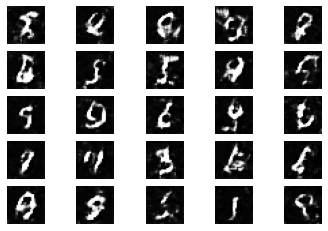

301 [Discriminator loss: 0.453981, Accuracy: 43.75%] [Generator loss: 2.605112]
302 [Discriminator loss: 0.406896, Accuracy: 50.00%] [Generator loss: 2.508327]
303 [Discriminator loss: 0.430960, Accuracy: 50.00%] [Generator loss: 2.067370]
304 [Discriminator loss: 0.418091, Accuracy: 50.00%] [Generator loss: 1.872363]
305 [Discriminator loss: 0.479012, Accuracy: 43.75%] [Generator loss: 2.181603]
306 [Discriminator loss: 0.601228, Accuracy: 40.62%] [Generator loss: 2.262124]
307 [Discriminator loss: 0.347336, Accuracy: 50.00%] [Generator loss: 2.137752]
308 [Discriminator loss: 0.421114, Accuracy: 40.62%] [Generator loss: 2.055153]
309 [Discriminator loss: 0.483766, Accuracy: 46.88%] [Generator loss: 2.098278]
310 [Discriminator loss: 0.684696, Accuracy: 28.12%] [Generator loss: 2.172916]
311 [Discriminator loss: 0.469958, Accuracy: 50.00%] [Generator loss: 2.045975]
312 [Discriminator loss: 0.518054, Accuracy: 43.75%] [Generator loss: 2.587788]
313 [Discriminator loss: 0.599996, Accur

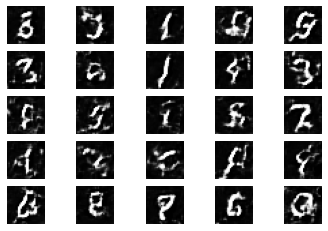

326 [Discriminator loss: 0.656544, Accuracy: 46.88%] [Generator loss: 1.732910]
327 [Discriminator loss: 0.447598, Accuracy: 46.88%] [Generator loss: 1.838815]
328 [Discriminator loss: 0.476182, Accuracy: 46.88%] [Generator loss: 1.521932]
329 [Discriminator loss: 0.451628, Accuracy: 43.75%] [Generator loss: 2.172387]
330 [Discriminator loss: 0.651286, Accuracy: 43.75%] [Generator loss: 1.804565]
331 [Discriminator loss: 0.478909, Accuracy: 40.62%] [Generator loss: 2.205195]
332 [Discriminator loss: 0.401264, Accuracy: 50.00%] [Generator loss: 2.167725]
333 [Discriminator loss: 0.413018, Accuracy: 46.88%] [Generator loss: 2.315102]
334 [Discriminator loss: 0.431692, Accuracy: 43.75%] [Generator loss: 2.000070]
335 [Discriminator loss: 0.437328, Accuracy: 50.00%] [Generator loss: 1.469024]
336 [Discriminator loss: 0.499616, Accuracy: 34.38%] [Generator loss: 2.037874]
337 [Discriminator loss: 0.390595, Accuracy: 50.00%] [Generator loss: 2.058579]
338 [Discriminator loss: 0.412607, Accur

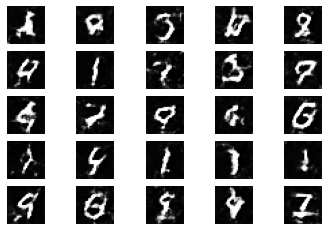

351 [Discriminator loss: 0.536290, Accuracy: 37.50%] [Generator loss: 1.753222]
352 [Discriminator loss: 0.506755, Accuracy: 40.62%] [Generator loss: 2.360126]
353 [Discriminator loss: 0.739386, Accuracy: 37.50%] [Generator loss: 1.644987]
354 [Discriminator loss: 0.474391, Accuracy: 40.62%] [Generator loss: 2.322775]
355 [Discriminator loss: 0.587939, Accuracy: 43.75%] [Generator loss: 2.423198]
356 [Discriminator loss: 0.487360, Accuracy: 46.88%] [Generator loss: 1.629410]
357 [Discriminator loss: 0.488056, Accuracy: 46.88%] [Generator loss: 2.119951]
358 [Discriminator loss: 0.416472, Accuracy: 46.88%] [Generator loss: 2.509771]
359 [Discriminator loss: 0.560513, Accuracy: 43.75%] [Generator loss: 1.864804]
360 [Discriminator loss: 0.566468, Accuracy: 34.38%] [Generator loss: 2.073535]
361 [Discriminator loss: 0.457569, Accuracy: 43.75%] [Generator loss: 1.898135]
362 [Discriminator loss: 0.537530, Accuracy: 46.88%] [Generator loss: 2.182318]
363 [Discriminator loss: 0.492540, Accur

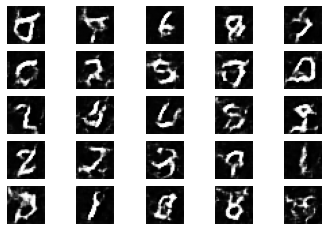

376 [Discriminator loss: 0.579286, Accuracy: 40.62%] [Generator loss: 2.566281]
377 [Discriminator loss: 0.479858, Accuracy: 50.00%] [Generator loss: 1.901816]
378 [Discriminator loss: 0.588618, Accuracy: 34.38%] [Generator loss: 1.466919]
379 [Discriminator loss: 0.650912, Accuracy: 31.25%] [Generator loss: 2.115700]
380 [Discriminator loss: 0.582785, Accuracy: 34.38%] [Generator loss: 2.462354]
381 [Discriminator loss: 0.517324, Accuracy: 50.00%] [Generator loss: 2.167409]
382 [Discriminator loss: 0.399270, Accuracy: 46.88%] [Generator loss: 2.166667]
383 [Discriminator loss: 0.428117, Accuracy: 43.75%] [Generator loss: 1.692384]
384 [Discriminator loss: 0.370557, Accuracy: 50.00%] [Generator loss: 2.231846]
385 [Discriminator loss: 0.577330, Accuracy: 43.75%] [Generator loss: 1.661385]
386 [Discriminator loss: 0.577760, Accuracy: 43.75%] [Generator loss: 2.193834]
387 [Discriminator loss: 0.453707, Accuracy: 46.88%] [Generator loss: 2.275097]
388 [Discriminator loss: 0.616841, Accur

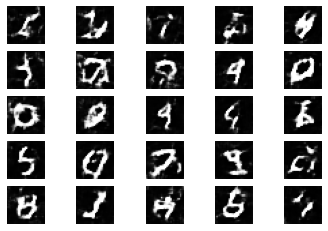

401 [Discriminator loss: 0.620889, Accuracy: 31.25%] [Generator loss: 1.912280]
402 [Discriminator loss: 0.414222, Accuracy: 50.00%] [Generator loss: 2.471642]
403 [Discriminator loss: 0.500850, Accuracy: 43.75%] [Generator loss: 1.734067]
404 [Discriminator loss: 0.452744, Accuracy: 46.88%] [Generator loss: 2.334875]
405 [Discriminator loss: 0.533336, Accuracy: 46.88%] [Generator loss: 1.840047]
406 [Discriminator loss: 0.548122, Accuracy: 40.62%] [Generator loss: 1.949494]
407 [Discriminator loss: 0.415036, Accuracy: 50.00%] [Generator loss: 2.700081]
408 [Discriminator loss: 0.551396, Accuracy: 46.88%] [Generator loss: 2.044291]
409 [Discriminator loss: 0.406338, Accuracy: 43.75%] [Generator loss: 2.753909]
410 [Discriminator loss: 0.580363, Accuracy: 43.75%] [Generator loss: 2.105805]
411 [Discriminator loss: 0.476928, Accuracy: 40.62%] [Generator loss: 2.322399]
412 [Discriminator loss: 0.434751, Accuracy: 50.00%] [Generator loss: 2.344040]
413 [Discriminator loss: 0.508292, Accur

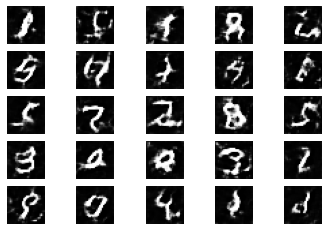

426 [Discriminator loss: 0.576311, Accuracy: 28.12%] [Generator loss: 1.968962]
427 [Discriminator loss: 0.633722, Accuracy: 43.75%] [Generator loss: 1.884679]
428 [Discriminator loss: 0.527153, Accuracy: 43.75%] [Generator loss: 1.791590]
429 [Discriminator loss: 0.580316, Accuracy: 34.38%] [Generator loss: 2.169868]
430 [Discriminator loss: 0.503906, Accuracy: 43.75%] [Generator loss: 2.260053]
431 [Discriminator loss: 0.675546, Accuracy: 40.62%] [Generator loss: 1.797513]
432 [Discriminator loss: 0.472334, Accuracy: 46.88%] [Generator loss: 2.233164]
433 [Discriminator loss: 0.515929, Accuracy: 50.00%] [Generator loss: 1.893051]
434 [Discriminator loss: 0.434177, Accuracy: 43.75%] [Generator loss: 1.906182]
435 [Discriminator loss: 0.360598, Accuracy: 50.00%] [Generator loss: 2.307575]
436 [Discriminator loss: 0.473915, Accuracy: 46.88%] [Generator loss: 2.850579]
437 [Discriminator loss: 0.447101, Accuracy: 50.00%] [Generator loss: 2.231827]
438 [Discriminator loss: 0.393142, Accur

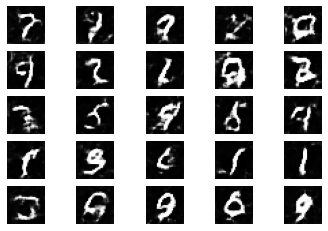

451 [Discriminator loss: 0.375976, Accuracy: 50.00%] [Generator loss: 2.137071]
452 [Discriminator loss: 0.421837, Accuracy: 50.00%] [Generator loss: 1.943880]
453 [Discriminator loss: 0.406895, Accuracy: 50.00%] [Generator loss: 2.856541]
454 [Discriminator loss: 0.515282, Accuracy: 46.88%] [Generator loss: 1.986046]
455 [Discriminator loss: 0.514254, Accuracy: 50.00%] [Generator loss: 1.729937]
456 [Discriminator loss: 0.588355, Accuracy: 28.12%] [Generator loss: 2.161465]
457 [Discriminator loss: 0.451503, Accuracy: 50.00%] [Generator loss: 1.850669]
458 [Discriminator loss: 0.442525, Accuracy: 50.00%] [Generator loss: 1.587144]
459 [Discriminator loss: 0.525580, Accuracy: 40.62%] [Generator loss: 2.065217]
460 [Discriminator loss: 0.625541, Accuracy: 46.88%] [Generator loss: 1.897957]
461 [Discriminator loss: 0.607360, Accuracy: 34.38%] [Generator loss: 2.055202]
462 [Discriminator loss: 0.537783, Accuracy: 46.88%] [Generator loss: 1.872050]
463 [Discriminator loss: 0.442811, Accur

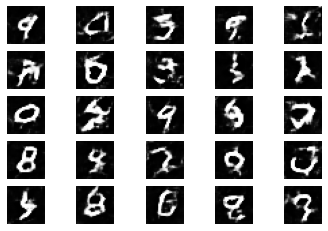

476 [Discriminator loss: 0.359592, Accuracy: 50.00%] [Generator loss: 2.581537]
477 [Discriminator loss: 0.562477, Accuracy: 40.62%] [Generator loss: 1.979509]
478 [Discriminator loss: 0.600512, Accuracy: 43.75%] [Generator loss: 1.809792]
479 [Discriminator loss: 0.502681, Accuracy: 43.75%] [Generator loss: 2.106862]
480 [Discriminator loss: 0.615794, Accuracy: 34.38%] [Generator loss: 2.444411]
481 [Discriminator loss: 0.419347, Accuracy: 50.00%] [Generator loss: 2.064578]
482 [Discriminator loss: 0.527628, Accuracy: 40.62%] [Generator loss: 1.883323]
483 [Discriminator loss: 0.522455, Accuracy: 40.62%] [Generator loss: 2.193305]
484 [Discriminator loss: 0.517655, Accuracy: 50.00%] [Generator loss: 2.472253]
485 [Discriminator loss: 0.498807, Accuracy: 46.88%] [Generator loss: 2.052468]
486 [Discriminator loss: 0.397960, Accuracy: 50.00%] [Generator loss: 2.050805]
487 [Discriminator loss: 0.498919, Accuracy: 50.00%] [Generator loss: 1.869480]
488 [Discriminator loss: 0.455220, Accur

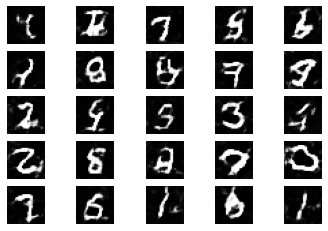

501 [Discriminator loss: 0.608219, Accuracy: 37.50%] [Generator loss: 1.885997]
502 [Discriminator loss: 0.450103, Accuracy: 50.00%] [Generator loss: 1.920559]
503 [Discriminator loss: 0.495547, Accuracy: 46.88%] [Generator loss: 1.824153]
504 [Discriminator loss: 0.563388, Accuracy: 40.62%] [Generator loss: 1.914958]
505 [Discriminator loss: 0.630916, Accuracy: 37.50%] [Generator loss: 2.109907]
506 [Discriminator loss: 0.622498, Accuracy: 40.62%] [Generator loss: 2.181983]
507 [Discriminator loss: 0.552945, Accuracy: 40.62%] [Generator loss: 2.128156]
508 [Discriminator loss: 0.423205, Accuracy: 46.88%] [Generator loss: 2.046358]
509 [Discriminator loss: 0.657914, Accuracy: 37.50%] [Generator loss: 1.608343]
510 [Discriminator loss: 0.434853, Accuracy: 46.88%] [Generator loss: 1.781069]
511 [Discriminator loss: 0.325939, Accuracy: 50.00%] [Generator loss: 2.699837]
512 [Discriminator loss: 0.380392, Accuracy: 50.00%] [Generator loss: 2.248680]
513 [Discriminator loss: 0.626327, Accur

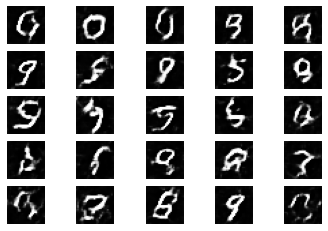

526 [Discriminator loss: 0.566473, Accuracy: 40.62%] [Generator loss: 1.842557]
527 [Discriminator loss: 0.434107, Accuracy: 46.88%] [Generator loss: 2.558716]
528 [Discriminator loss: 0.489505, Accuracy: 43.75%] [Generator loss: 2.550155]
529 [Discriminator loss: 0.594133, Accuracy: 40.62%] [Generator loss: 2.475205]
530 [Discriminator loss: 0.461232, Accuracy: 50.00%] [Generator loss: 2.353925]
531 [Discriminator loss: 0.565818, Accuracy: 46.88%] [Generator loss: 1.539778]
532 [Discriminator loss: 0.576230, Accuracy: 34.38%] [Generator loss: 2.096538]
533 [Discriminator loss: 0.567535, Accuracy: 50.00%] [Generator loss: 1.877384]
534 [Discriminator loss: 0.452704, Accuracy: 43.75%] [Generator loss: 1.848392]
535 [Discriminator loss: 0.418322, Accuracy: 50.00%] [Generator loss: 2.454526]
536 [Discriminator loss: 0.531149, Accuracy: 46.88%] [Generator loss: 2.334817]
537 [Discriminator loss: 0.381895, Accuracy: 50.00%] [Generator loss: 1.880166]
538 [Discriminator loss: 0.496733, Accur

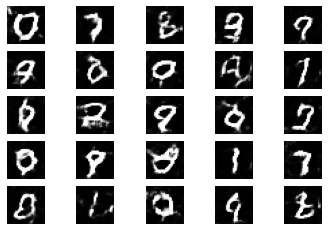

In [14]:
train(551, 32, 25)
# generator.save('mnist_model.h5')

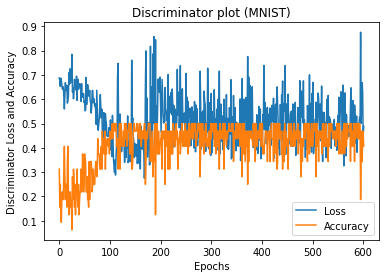

In [16]:
plot.plot(totalDiscriminatorLossandAcc)
plot.title('Discriminator plot (MNIST)')
plot.xlabel('Epochs')
plot.ylabel('Discriminator Loss and Accuracy')
plot.legend(['Loss', 'Accuracy'])
plot.show()

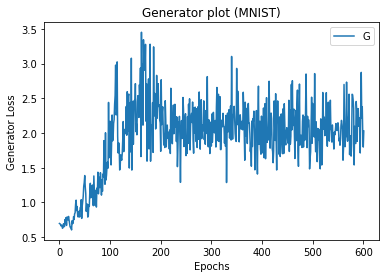

In [19]:
plot.plot(generatorLoss)
plot.title('Generator plot (MNIST)')
plot.xlabel('Epochs')
plot.ylabel('Generator Loss')
plot.legend('Gen Loss')
plot.show()